imports

In [1]:
from ultralytics import YOLO

import os
from PIL import Image

import torch
from torchvision import transforms

import matplotlib.pyplot as plt

THEORY :

Yolo solves the problem of rotation and scaling issues when it comes to Localizing objects in images. 

While localizing objects in an image, we could have a fixed kernel move through the image pixel by pixel (stride-wise) and check if the object's features are present in the kernel and then bound it. This process called Sliding window. 
But this is highly expensive and will fail due to Scaling and Rotation issues. (When the object is smaller than said kernel's size, it won't recognize it).  

In essence, its an algorithm that aims to minimize the loss while drawing bounding boxes while classifying multiple images and obviously identify/localize/classify multiple objects in an image.

Traditional Yolo architecture divides the image into a 7x7 grid where each grid is required to have only 1 object's centre at most. We do this by refining the grid and essentially increasing the number of grids from 7x7 to maybe 11x11 or something like that. 

Each pixel (point) on the grid is normalized to stay between 0 and 1. So each point can be (0,0) to (1,1).

Each grid has a vector associated with it that corresponds to the object class, confidence value, probability and position coordinates of the object. So for instance, if a grid has no object, the probability value is 0 and other parameters don't matter.

Note: If a certain grid has a part of some object that's not the centre of the object, the probability value is 0. Basically the vector has probability is 1 when a particular grid has the centre of the object. 

The vector looks like this : [p1 , bx , by . bw , bh ,
                             p2 , bx , by , bw , bh ,
                             c1 , c2 , c3] (for 3 classes). 
                             
Essecntially, we have 2 bounding boxes per grid cell and whichever is more accurate, we take that bounding box and consequently that object. During training, it considers 2 boxes and uses the one that gets the better confidence score. 

bx is the x-axis position of the centre of said object with repect to the top left corner of the grid.
by is the y-axis position of the centre of said object with repect to the top left corner of the grid.
c_ refers to the class of the object. 
p refers to the probability. 
bw and bh refer to the length and height of the bounding box (may or may not be more than 1).

So we get a long vector for each grid cell: (5 x B) + C. 

Hence in the end we get S x S x (5B + C) values for all the grid cells in the image. 
 
Essentially, we are trying to guess two places in the grid where the box might be taking the one with a higher confidence score. 

Only one of the bounding boxes is responsible for the probability and class score of that grid cell. 
This is chosen with the highest IOU (intersection over union with the ground truth box) score.
IOU measures the overlap between each of the bounding and the ground truth box. 
IOU = Area of overlap / Area of Union. Higher IOU directly means overlap = union, hence making a particular bounding box a tight exact fit for the object. 

Loss : There are 3 major components to the loss used in Yolo.
Localization loss - Model minimizes the x and y offset losses of the responsible bounding box.
Confidence loss - Tunes the model to predict how good the fit of the box is.
Classification loss - Tunes the model to predict the correct class in each grid cell.
All losses are MSE.

Anchor boxes : 
Its reasonable to assume that some objects' bounding boxes lie in a certain way. Like a person's bounding box will lie as a vertical rectangle and a car's will be a horizontal rectangle.
Having pre-defined anchor boxes lets us have multiple objects in the same grid, thereby reducing computation. 

Anchor boxes have been implemented from Yolo2 onwards to reduce complexity and improve multiple object detection.


instantiating gpu use

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


inspecting the dataset for sanity check

In [3]:
TRAIN_IMG_DIR = 'data/images/train'
VAL_IMG_DIR  = 'data/images/val'
TEST_IMG_DIR = 'data/images/test'

In [4]:
print(f"total training cow images: {len(os.listdir(TRAIN_IMG_DIR))}")
print(f"total validation cow images: {len(os.listdir(VAL_IMG_DIR))}")
print(f"total testing cow images: {len(os.listdir(TEST_IMG_DIR))}")

total training cow images: 169
total validation cow images: 21
total testing cow images: 19


In [5]:
TRAIN_LABELS_DIR = 'data/labels/train'
VAL_LABELS_DIR  = 'data/labels/val' 
TEST_LABELS_DIR = 'data/labels/test'

In [6]:
print(f"total training cow labels: {len(os.listdir(TRAIN_LABELS_DIR))}")
print(f"total validation cow labels: {len(os.listdir(VAL_LABELS_DIR))}")
print(f"total testing cow labels: {len(os.listdir(TEST_LABELS_DIR))}")

total training cow labels: 169
total validation cow labels: 21
total testing cow labels: 19


sample snippet of the cows

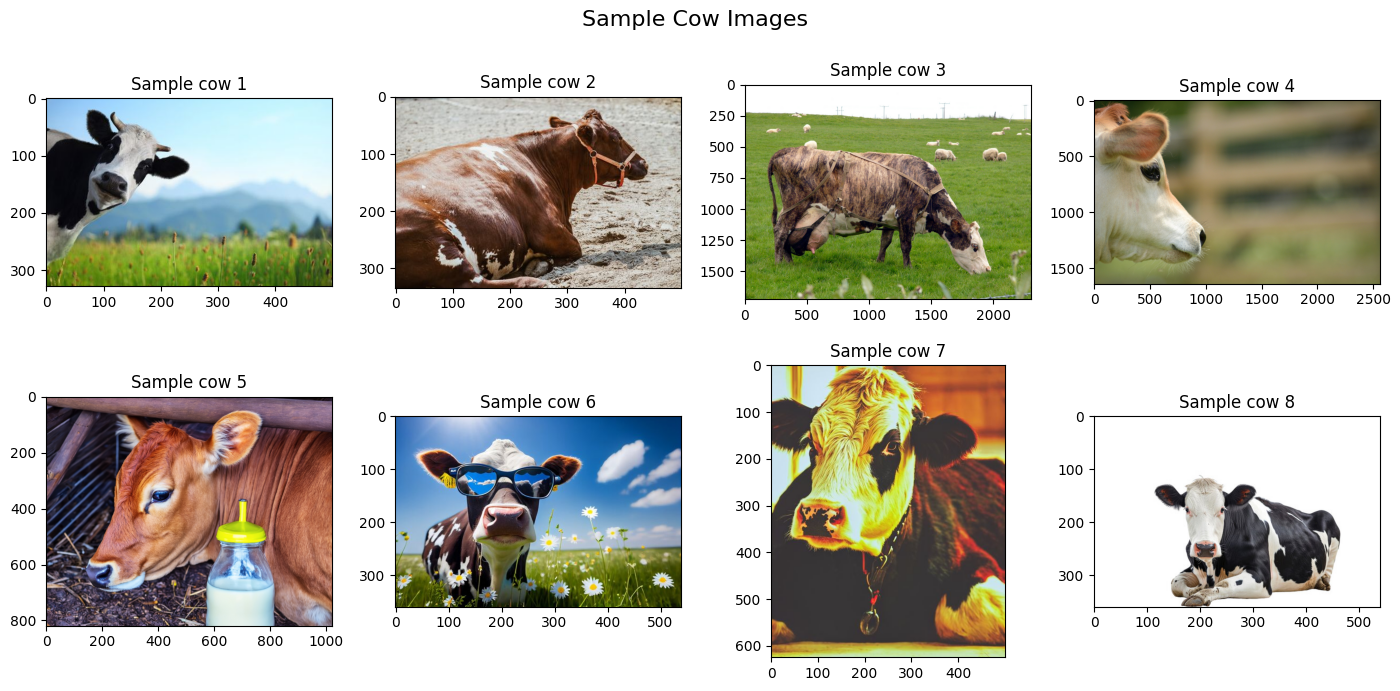

In [7]:
cow_images = [os.path.join(TRAIN_IMG_DIR, filename) for filename in os.listdir(TRAIN_IMG_DIR) 
                if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Sample Cow Images', fontsize=16)

for i, cow_image in enumerate(cow_images[:8]):
    img = Image.open(cow_image)
    row = i // 4  
    col = i % 4   
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Sample cow {i+1}')

plt.tight_layout()
plt.show()

prefer to chose yolov11n model considering how small the dataset is

In [8]:
model = YOLO('yolo11n.pt')
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

setting up the model for training and augmenting for better results

In [9]:
model.train(
    project=".",              
    name="results", 
    exist_ok=True,           
    
    # SETUP
    data='config.yaml',
    epochs=120,            
    patience=10,           
    batch=8,               
    device=0,
    freeze=10,              
    optimizer='Adam',
    lr0=0.0003,            
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=5,       
    warmup_bias_lr=0.1,
    dropout=0.25,           
    
    # DATA AUGMENTATION 
    degrees=45.0,          
    scale=0.15,            
    translate=0.08,        
    perspective=0.0003,    
    shear=2.0,             
    fliplr=0.5,
    hsv_h=0.02,            
    hsv_s=0.7,             
    hsv_v=0.4,             
    mixup=0.1,             
    copy_paste=0.2,                     
)

Ultralytics 8.3.203 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7797MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yaml, degrees=45.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.25, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.02, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=results, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0003, plots=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f29941246e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

making predictions on unseen/test data

In [10]:
model = YOLO('results/weights/best.pt')

testing = model.val(
    project=".",
    name="validation",
    exist_ok=True,
    
    data='config.yaml',
    split='test',
    batch=8,
    conf=0.3,
    
    plots=True,          
    save_json=True  
)

Ultralytics 8.3.203 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7797MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 620.2±613.9 MB/s, size: 337.0 KB)
val: Scanning /home/pranav/Projects/yolo/data/labels/test... 19 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 19/19 2.6Kit/s 0.0s
val: New cache created: /home/pranav/Projects/yolo/data/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.2it/s 1.4s0.6s
                   all         19         25      0.916       0.96      0.971      0.555
Speed: 2.2ms preprocess, 29.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving /home/pranav/Projects/yolo/validation/predictions.json...
Results saved to /home/pranav/Projects/yolo/validation
